In [12]:

import sys
import os
import pickle
# from scipy.misc import imread
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as imread
import math
import random

# example methods to calculate epipolar distance and sfm

In [13]:
def point_from_epipolar(known_point,unknown_point,foe,debug=False):
# define a line known_point<--->foe and get the distance
    line=np.cross(known_point,foe)
    line=line/(np.linalg.norm(line[:2]))
    d=unknown_point.dot(line)
    if debug:
        print(line, d)
        t=np.arange(0,2*np.pi,0.01)
        s=np.sin(t)
        c=np.cos(t)
        plt.figure("epi")
        plt.plot(known_point[0],known_point[1],"+r",markersize=5)
        plt.plot(foe[0],foe[1],"+b",markersize=5)
        plt.plot(unknown_point[0],unknown_point[1],".b",markersize=5)
        plt.plot(t,-(t*line[0]+line[2])/line[1])
        plt.plot(d*s+unknown_point[0],d*c+unknown_point[1],'k')
    return np.abs(d)


def ZfromTracking(pcurr,pprev,RcFp,TcFp):
    pfoe=TcFp/TcFp[2]
    prot = RcFp.dot(pprev)
    prot = prot/prot[2,:] # normalized
    d = pcurr-prot
    n = pfoe-prot
    Zx = TcFp[2] *n[0,:]/d[0,:]
    Zy = TcFp[2] *n[1,:]/d[1,:]
    return Zx, Zy

# load data for the sequence from pickle

In [14]:


with open('data.pkl', 'rb') as pklfile:
    data = pickle.load(pklfile, fix_imports=True,encoding="latin1")
focal_length = data['flx']
pp = data['principle_point']
EM = data['egomotion_18-19']
point_18 = data['points_18']
point_19 = data['points_19']
points_18 = data['points_18'][0] - pp #extract the labels and substarct the pp
points_19 = data['points_19'][0] - pp 
R = EM[:3, :3]
T = EM[:3, 3]
foe = EM[:3, 3] / EM[2, 3]
foe[:2] *= focal_length


In [15]:
# print(f"pp {pp}")
# print(points_18)
# print(points_19)
# print(focal_length)
print(EM)
print(f"R {R}")
print(f"T {T}")


[[ 9.99999670e-01  1.52861218e-04  7.98200539e-04  1.36003858e-02]
 [-1.53764976e-04  9.99999347e-01  1.13230576e-03  2.00927786e-02]
 [-7.98026932e-04 -1.13242812e-03  9.99999040e-01 -5.87280916e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R [[ 9.99999670e-01  1.52861218e-04  7.98200539e-04]
 [-1.53764976e-04  9.99999347e-01  1.13230576e-03]
 [-7.98026932e-04 -1.13242812e-03  9.99999040e-01]]
T [ 0.01360039  0.02009278 -0.58728092]


# visualize the data

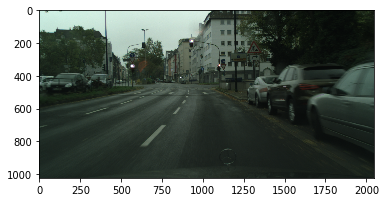

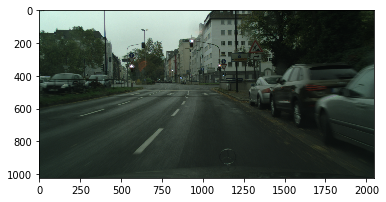

In [16]:
with open(r'dusseldorf_000049_000018_leftImg8bit.png', 'rb') as imgfile:
    img1 = plt.imread(imgfile)
with open(r'dusseldorf_000049_000019_leftImg8bit.png', 'rb') as imgfile:
    img2 = plt.imread(imgfile)

plt.figure('frame 18')
plt.imshow(img1)
# plt.scatter(points_18[0][:, 0], points_18[0][:, 1])
plt.figure('frame 19')
plt.imshow(img2)
# plt.scatter(points_19[0][:, 0], points_19[0][:, 1])
plt.show()

# find match for the first point

In [17]:
idx = 0
possible_matches = []
color = points_18[1][idx]
point = points_18[0][idx]
#creating homogonize vector and substracting the principle point to have the point in sfm coordinate system
pt1 = np.ones(3)
pt1[0] = point[0] - pp[0]
pt1[1] = point[1] - pp[1]
for jdx, point1 in enumerate(points_19[0]):
    if color == points_19[1][jdx]: # only matching if same color
        pt2 = np.ones(3)
        pt2[0] = point1[0] - pp[0]
        pt2[1] = point1[1] - pp[1]
        epipolar_distance = point_from_epipolar(pt2, pt1, foe)
        possible_matches.append((epipolar_distance, jdx))
possible_matches = sorted(possible_matches, key=lambda x: x[0])
# choosing the point with the same color and lowest epipolar distance as match
point1 = points_19[0][possible_matches[0][1]]
pt2 = np.ones(3)
pt2[0] = point1[0] - pp[0]
pt2[1] = point1[1] - pp[1]
pt2[:2] /= focal_length
pt1[:2] /= focal_length
#calculating depth from sfm
zx, zy = ZfromTracking(pt2[:, np.newaxis], pt1[:, np.newaxis], EM[:3, :3], EM[:3, 3][:, np.newaxis])
print(zx, zy)

IndexError: invalid index to scalar variable.

## Rotate lights in previous image

In [19]:

def rotate_prev_points(points, R):
    rotate_points = []
    for p in points:
        prev = np.append(p ,focal_length)
        prev = np.matmul(R,prev)
        rotate_points.append(list(prev))
    return np.array(rotate_points)
previous_rotate=rotate_prev_points(points_18,R)




In [20]:
print(previous_rotate)
print(type(previous_rotate))


[[-525.19893128 -168.49241786 2264.52306739]
 [-163.22259146 -322.54798024 2264.40857557]
 [   6.79997586 -174.57421691 2264.10531163]
 [-281.69557232 -146.02987432 2264.3032682 ]
 [-229.68855787 -100.03790014 2264.2096791 ]
 [  28.80929313 -113.57763957 2264.01867692]]
<class 'numpy.ndarray'>


## Epipolar line
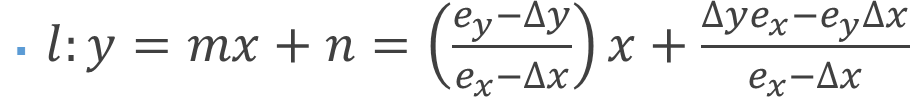

In [21]:
def calculate_epipolar_line(point):
    ex,ey=foe[:2]
    x,y=point[:2]
    m=(ey-y)/(ex-x)
    n=(y*ex-ey*x)/(ex-x)
    return m,n
    


In [22]:
calculate_epipolar_line(previous_rotate[0])
# print(previous_rotate[0][:2])

(0.1925599347867184, -67.36014590582859)

## Distance of point from line
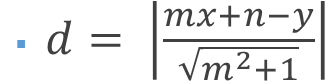

In [23]:
def random_color():
    rgbl=[255,0,0]
    random.shuffle(rgbl)
    return tuple(rgbl)

In [24]:
def distance_point_from_line(previous_point,current_point):
    m,n=calculate_epipolar_line(current_point)
    x,y=previous_point[:2]
    d=abs((m*x+n-y)/math.sqrt(m**2+1))
    return d
    

In [25]:
current=points_19
# print(current)
distance=distance_point_from_line(previous_rotate[0],current[0])
print(f"distance : {distance}")


distance : 0.5153840812872366


# Match rotated points to current points


In [26]:
def match_rotated_point_to_current_point(previous_points,current_points):
#     xc,yc=current_points
#     xr,yr=previous_points
    match_point=[]
    for prev in previous_points:
        distance_array=[]
        for current in current_points:
            d=distance_point_from_line(prev,current)
            distance_array.append(d)
        distance_array=np.array(distance_array)
        min_index=np.argmin(distance_array, axis=0)
        match_point.append((prev[:2],current_points[min_index]))
  
    return np.array(match_point)
match_point=match_rotated_point_to_current_point(previous_rotate,current)
print(match_point)

[[[-525.19893128 -168.49241786]
  [-530.98       -170.137     ]]

 [[-163.22259146 -322.54798024]
  [-164.98       -325.137     ]]

 [[   6.79997586 -174.57421691]
  [   7.02       -176.137     ]]

 [[-281.69557232 -146.02987432]
  [-282.48       -146.137     ]]

 [[-229.68855787 -100.03790014]
  [-229.98       -100.137     ]]

 [[  28.80929313 -113.57763957]
  [  29.52       -114.137     ]]]


[-525.19893128 -168.49241786]


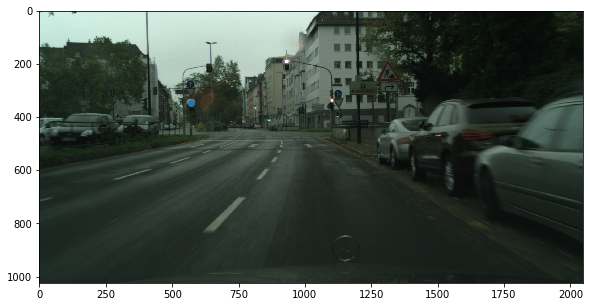

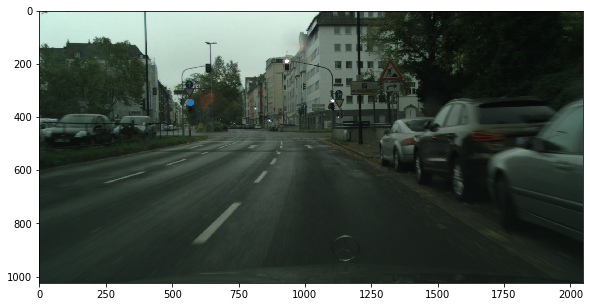

In [27]:
match_point=match_rotated_point_to_current_point(previous_rotate,current)

def color_matches(matches, img_18, img_19):
    plt.figure(figsize=(10,5))
    plt.imshow(img1)
    print(matches[0][0])
    plt.scatter(matches[0][0][0]+pp[0], matches[0][0][1]+pp[1])
    plt.figure(figsize=(10,5))
    plt.imshow(img2)
    plt.scatter(matches[0][1][0]+pp[0], matches[0][1][1]+pp[1])
    plt.show()
color_matches(match_point,img1,img2)

# Calculate Z distance from tracking(SFM calculation)

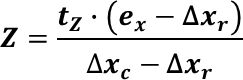

In [28]:
match_point=match_rotated_point_to_current_point(previous_rotate,current)
def SFM_calculation(matches):
    depth = []
    for match in matches:
        prev= match[0]
        current= match[1]
        e = foe[:2]
        tz = T[2]
        Z = tz*((e - prev)/(current - prev))
        depth.append((Z,current))
    return depth

depth = SFM_calculation(match_point)

print(depth)

[(array([48.02732183, 32.50924346]), array([-530.98 , -170.137])), (array([37.02465866, 55.59556369]), array([-164.98 , -325.137])), (array([158.08973466,  36.49632894]), array([   7.02 , -176.137])), (array([171.64663521, 375.93506716]), array([-282.48 , -146.137])), (array([357.19491485, 133.82550333]), array([-229.98 , -100.137])), (array([67.12923673, 37.92495601]), array([  29.52 , -114.137]))]


## plot distance on current image

In [61]:
def Weighted_average_z(z):
#     return np.average(, weights=range(10,0,-1))
    zx,zy=z
    return np.square(zx**2+zy**2)

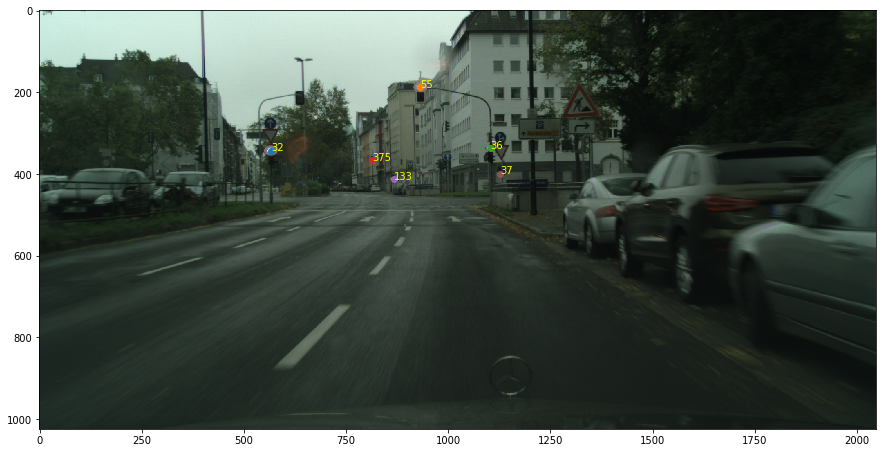

In [63]:
def calc_depth(depth):
    plt.figure(figsize=(15,15))
    plt.imshow(img2)
    for d in depth:
        Zx, Zy = d[0]
        Z=Weighted_average_z( d[0])
        current_point = d[1] + pp
        real_point =d[1] * (Z/focal_length)
        plt.scatter(current_point[0],current_point[1])
        plt.annotate(int(Zy),(current_point[0],current_point[1]),color='yellow')
#         print(real_point)
    plt.show()
    
match_point=match_rotated_point_to_current_point(previous_rotate,current)    
d = SFM_calculation(match_point)
calc_depth(d)

# Calculate 3D position of each light


In [53]:
def calcuate_position(z):
    return z/focal_length
s=calcuate_position(z)
print(s)

[[[ 0.02121432  0.01435977]
  [-0.23454103 -0.07515181]]

 [[ 0.01635429  0.02455731]
  [-0.07287389 -0.1436174 ]]

 [[ 0.06983037  0.01612092]
  [ 0.00310083 -0.07780209]]

 [[ 0.07581864  0.16605559]
  [-0.12477523 -0.06455069]]

 [[ 0.15777782  0.05911253]
  [-0.10158527 -0.04423186]]

 [[ 0.02965189  0.01675196]
  [ 0.01303938 -0.05041585]]]


In [51]:
z = SFM_calculation(match_point)
# print(z)
def Weighted_average_z(z):
#     return np.average(, weights=range(10,0,-1))
    return np.square(z)
average_z=Weighted_average_z(z)
print(average_z)


[[[2.30662364e+03 1.05685091e+03]
  [2.81939760e+05 2.89465988e+04]]

 [[1.37082535e+03 3.09086670e+03]
  [2.72184004e+04 1.05714069e+05]]

 [[2.49923642e+04 1.33198203e+03]
  [4.92804000e+01 3.10242428e+04]]

 [[2.94625674e+04 1.41327175e+05]
  [7.97949504e+04 2.13560228e+04]]

 [[1.27588207e+05 1.79092653e+04]
  [5.28908004e+04 1.00274188e+04]]

 [[4.50633442e+03 1.43830229e+03]
  [8.71430400e+02 1.30272548e+04]]]


In [54]:
def calcuate_position(s,current_point,z):

     return s*current_point[:2]
points=calcuate_position(s,current,z)
print(points)

[[[-11.26437767  -2.44312847]
  [ 38.69457962  24.43463384]]

 [[ -8.68380169  -4.1781072 ]
  [ 12.02273484  46.69533107]]

 [[-37.07852967  -2.74276515]
  [ -0.51157473  25.29633825]]

 [[-40.25817913 -28.2522005 ]
  [ 20.58541725  20.9878162 ]]

 [[-83.77686431 -10.05722871]
  [ 16.75953788  14.38141573]]

 [[-15.74456053  -2.85012906]
  [ -2.15123732  16.39205935]]]
